/var/folders/44/76qc6g0n2v3_y143g2hm4rtr0000gq/T/ipykernel_24822/3727844695.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  climo_region_total = float((climo_mjj * mask).sum(['latitude', 'longitude']).values)
/var/folders/44/76qc6g0n2v3_y143g2hm4rtr0000gq/T/ipykernel_24822/3727844695.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_2023_region_total = float((data_2023_mjj * mask).sum(['latitude', 'longitude']).values)
/var/folders/44/76qc6g0n2v3_y143g2hm4rtr0000gq/T/ipykernel_24822/3727844695.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extrac

NameError: name 'region_title_name' is not defined

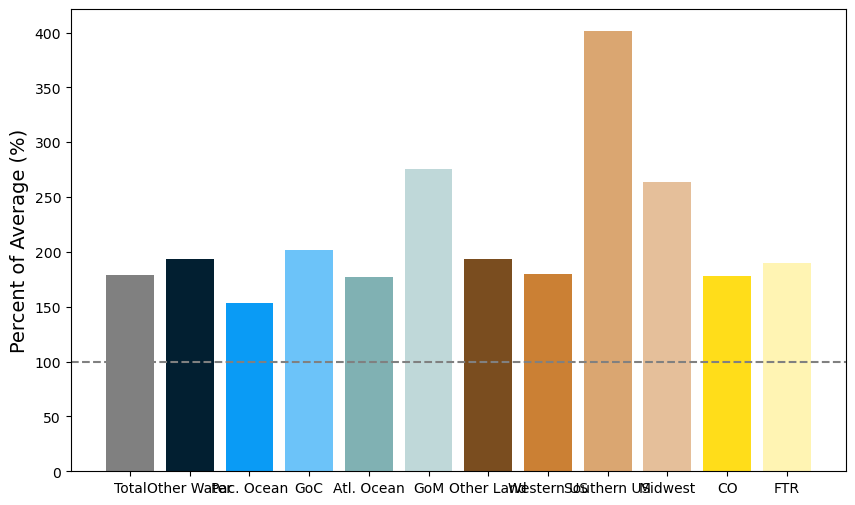

In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import glob
from datetime import datetime
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# SETTINGS
plot_sink_regions = ['nfr', 'pp', 'sp']  # Sink regions
months = [5, 6, 7]  # May, June, July
region_info = pd.read_csv("/Users/kathum/Research/COPEX/sink_region_files/source_region_information.csv")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
save_plots = True

# Custom colormap from original bar plots
my_cmap = ListedColormap([
    "grey","#021f31", "#0a9bf5", '#6cc3f9', '#80b1b3', '#bfd8d9', 
    '#7a4d1f', '#cb8034', '#daa671', '#e5bf9a', "#ffdd1a", "#fff4b3"
])

# Initialize DataFrame for % of average
all_regions_percent_of_avg = pd.DataFrame()

for sink_region_name in plot_sink_regions:
    region_alt_acronym = region_info.loc[region_info['other_acronym'] == sink_region_name, 'short_name'].item()

    DATA_DIRECTORY = '/Users/kathum/Research/COPEX/aggregated_files/wam_output/aggregated_co_altclimate_' + sink_region_name + '_2000_2023/'
    SAVE_DIRECTORY = '/Users/kathum/Research/COPEX/figures/2000-2023_'+sink_region_name+'/'+ datetime.today().strftime('%m_%d_%Y') +'/'
    SINK_R_DIRECTORY = '/Users/kathum/Research/COPEX/sink_region_files/masks/' #Where the sink region netCDFs are located
    #create a new directory if needed
    if save_plots == True:
        if not os.path.exists(SAVE_DIRECTORY):
            os.makedirs(SAVE_DIRECTORY)
            print('created new directory at: ', SAVE_DIRECTORY)
            
    # Get file list for selected months
    files = []
    for month_num in months:
        files.extend(glob.glob(DATA_DIRECTORY + "*" + f'-{month_num:02}.nc'))
    files = sorted(files)

    # Load climatology (2000–2022)
    climo_ds = xr.open_mfdataset(files).sel(time=slice('2000-01-01', '2022-12-31'))['e_track']

    # Load 2023
    data_2023_ds = xr.open_mfdataset(files).sel(time=slice('2023-01-01', '2023-12-31'))['e_track']

    # Compute cumulative MJJ totals for climatology and 2023
    climo_mjj = climo_ds.sel(time=climo_ds.time.dt.month.isin(months)).mean(dim='time')
    data_2023_mjj = data_2023_ds.sel(time=data_2023_ds.time.dt.month.isin(months)).mean(dim='time')

    # Total for entire sink region
    climo_total = float(climo_mjj.sum(['latitude', 'longitude']).values)
    data_2023_total = float(data_2023_mjj.sum(['latitude', 'longitude']).values)

    # Percent of average for total
    total_percent_of_avg = (data_2023_total / climo_total) * 100 if climo_total != 0 else np.nan

    # Percent of average per source region
    sel_region_info = region_info[
        (~region_info['clim_division']) | (region_info['other_acronym'] == sink_region_name)
    ]

    region_percentages = {'sink_region': sink_region_name, 'Total': total_percent_of_avg}
    region_names = []

    for i, region in sel_region_info.iterrows():
        mask = xr.open_dataarray(region['mask_filepath'])

        # Exclude sink region from mask if needed
        if region['region_name'].capitalize() == 'Colorado':
            remove_mask = xr.open_dataarray(region_info.loc[region_info['other_acronym'] == sink_region_name, 'mask_filepath'].item())
            mask = mask - remove_mask
            mask = mask.where(mask > 0, other=0)
            remove_mask.close()

        # Contribution for climatology and 2023
        climo_region_total = float((climo_mjj * mask).sum(['latitude', 'longitude']).values)
        data_2023_region_total = float((data_2023_mjj * mask).sum(['latitude', 'longitude']).values)

        # Percent of average
        if climo_region_total != 0:
            pct_of_avg = (data_2023_region_total / climo_region_total) * 100
        else:
            pct_of_avg = np.nan  # Avoid division by zero

        region_percentages[region['short_name']] = pct_of_avg
        region_names.append(region['short_name'])
        mask.close()

    # Append to master DataFrame
    all_regions_percent_of_avg = pd.concat(
        [all_regions_percent_of_avg, pd.DataFrame([region_percentages])],
        ignore_index=True
    )

    # Plot bar chart for this sink region
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = list(region_percentages.keys())[1:]  # Skip 'sink_region'
    values = [region_percentages[bar] for bar in bars]

    ax.bar(bars, values, color=my_cmap.colors[:len(bars)])
    ax.axhline(100, color='gray', linestyle='--', label='Climatology Average')

    # Labels and title
    ax.set_ylabel('Percent of Average (%)', fontsize=14)
    ax.set_title(f'May-July of 2023 Percent of Average Contribution\n to {region_title_name[sink_region_name]} Precipitation', fontsize=16)
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim([0, max(120, max(values) * 1.2)])  # Adjust y-limit for clarity

    # Annotate bars
    for i, v in enumerate(values):
        ax.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.savefig(f'{SAVE_DIRECTORY}percent_of_average_{sink_region_name}.png', dpi=300)
    plt.show()

    print(f"Plot saved for {sink_region_name}")

# # Save % of average data
# all_regions_percent_of_avg.to_csv(f'{SAVE_DIRECTORY}regional_percent_of_average_summary.csv', index=False)
# print("Summary CSV saved.")
